In [24]:
!pip install -q transformers datasets evaluate rouge_score sentencepiece sacrebleu

In [38]:
!apt-get install -y sentencepiece

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libsentencepiece0
The following NEW packages will be installed:
  libsentencepiece0 sentencepiece
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 887 kB of archives.
After this operation, 2,790 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsentencepiece0 amd64 0.1.96-1build1 [832 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 sentencepiece amd64 0.1.96-1build1 [54.5 kB]
Fetched 887 kB in 1s (690 kB/s)
Selecting previously unselected package libsentencepiece0.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../libsentencepiece0_0.1.96-1build1_amd64.deb ...
Unpacking libsentencepiece0 (0.1.96-1build1) ...
Selecting previously unselected package sentencepiece.
Preparing to unpack .../sentence

In [39]:
!spm_train --version

sentencepiece 0.1.96


## 1. Tiền xử lý dữ liệu & Tokenizer

In [64]:
# Đọc và kiểm tra dữ liệu mẫu
import os

data_dir = "/content/data"
files = ["train.en.txt", "train.vi.txt", "tst2012.en.txt", "tst2012.vi.txt", "tst2013.en.txt", "tst2013.vi.txt"]

for file in files:
    path = os.path.join(data_dir, file)
    print(f"\n--- {file} ---")
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i < 5:
                print(line.strip())
            else:
                break


--- train.en.txt ---
Rachel Pike : The science behind a climate headline
In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .
I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
Headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .
They are both two branches of the same field of atmospheric science .

--- train.vi.txt ---
Khoa học đằng sau một tiêu đề về khí hậu
Trong 4 phút , chuyên gia hoá học khí quyển Rachel Pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu , cùng với đoàn nghiên cứu của mình -- hàng ngàn người đã cống 

In [65]:
# Thống kê số lượng dòng trong từng file
def count_lines(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return sum(1 for _ in f)

print("Số lượng dòng trong từng file:")
for file in files:
    path = os.path.join(data_dir, file)
    print(f"{file}: {count_lines(path)} lines")

Số lượng dòng trong từng file:
train.en.txt: 133317 lines
train.vi.txt: 133317 lines
tst2012.en.txt: 1553 lines
tst2012.vi.txt: 1553 lines
tst2013.en.txt: 1268 lines
tst2013.vi.txt: 1268 lines


In [66]:
# Hàm tiền xử lý văn bản
import re

def clean_text(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)           # Chuẩn hóa khoảng trắng
    text = re.sub(r'[^\w\s.,!?@:/\-\(\)]', '', text)  # Loại bỏ ký tự đặc biệt không mong muốn
    return text.lower()                         # Chuyển về chữ thường

In [67]:
# Áp dụng tiền xử lý lên tất cả các file
for file in files:
    input_path = os.path.join(data_dir, file)
    output_path = os.path.join(data_dir, file.replace(".txt", ".cleaned.txt"))

    with open(input_path, "r", encoding="utf-8") as infile, \
         open(output_path, "w", encoding="utf-8") as outfile:
        for line in infile:
            cleaned = clean_text(line)
            if cleaned:
                outfile.write(cleaned + "\n")

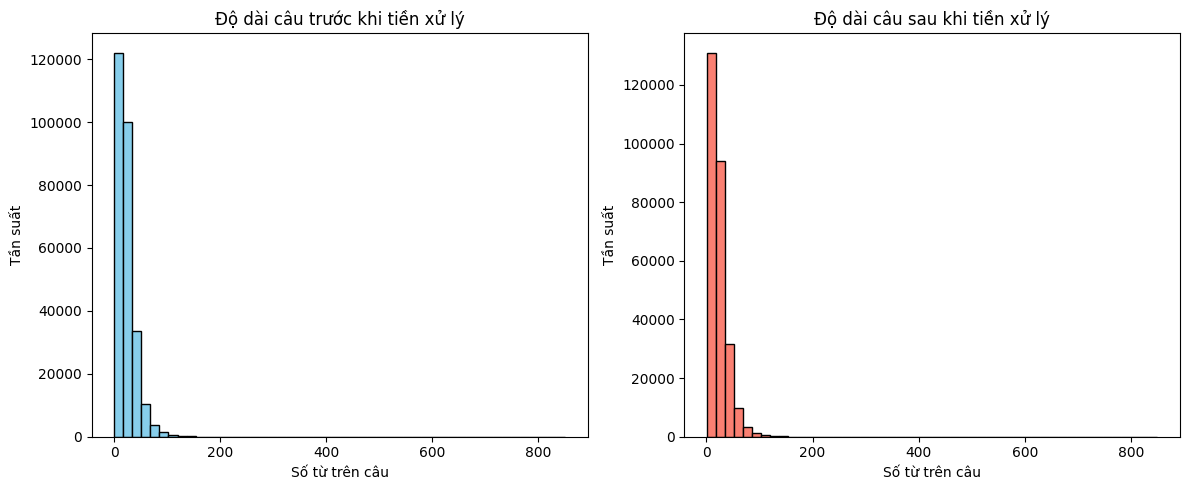


--- Thống kê độ dài câu ---
Trước tiền xử lý: Trung bình = 22.6, Trung vị = 18.0
Sau tiền xử lý: Trung bình = 22.6, Trung vị = 18.0


In [68]:
# Thống kê độ dài câu trước và sau khi tiền xử lý
import matplotlib.pyplot as plt

def analyze_lengths(file_paths):
    lengths = []
    for path in file_paths:
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                lengths.append(len(line.strip().split()))
    return lengths

# So sánh độ dài câu trước và sau khi làm sạch
before_files = [os.path.join(data_dir, f) for f in files]
after_files = [os.path.join(data_dir, f.replace(".txt", ".cleaned.txt")) for f in files]

before_lengths = analyze_lengths(before_files)
after_lengths = analyze_lengths(after_files)

# Biểu đồ so sánh
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(before_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Độ dài câu trước khi tiền xử lý")
plt.xlabel("Số từ trên câu")
plt.ylabel("Tần suất")

plt.subplot(1, 2, 2)
plt.hist(after_lengths, bins=50, color='salmon', edgecolor='black')
plt.title("Độ dài câu sau khi tiền xử lý")
plt.xlabel("Số từ trên câu")
plt.ylabel("Tần suất")

plt.tight_layout()
plt.show()

# Thống kê mô tả
import numpy as np
print("\n--- Thống kê độ dài câu ---")
print(f"Trước tiền xử lý: Trung bình = {np.mean(before_lengths):.1f}, Trung vị = {np.median(before_lengths):.1f}")
print(f"Sau tiền xử lý: Trung bình = {np.mean(after_lengths):.1f}, Trung vị = {np.median(after_lengths):.1f}")

In [69]:
# Tạo tập hợp dữ liệu để huấn luyện tokenizer BPE
all_cleaned_files = [os.path.join(data_dir, f.replace(".txt", ".cleaned.txt")) for f in files]

with open(os.path.join(data_dir, "all_combined.txt"), "w", encoding="utf-8") as outfile:
    for file in all_cleaned_files:
        with open(file, "r", encoding="utf-8") as infile:
            for line in infile:
                outfile.write(line)

In [70]:
# Huấn luyện tokenizer BPE (SentencePiece)
%%bash
spm_train --input=/content/data/all_combined.txt \
          --model_prefix=bpe \
          --vocab_size=32000 \
          --character_coverage=1.0 \
          --model_type=bpe

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /content/data/all_combined.txt
  input_format: 
  model_prefix: bpe
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  esc

In [71]:
# Mã hóa dữ liệu thành token ID bằng BPE
from sentencepiece import SentencePieceProcessor

sp = SentencePieceProcessor(model_file='bpe.model')

def tokenize_file(input_path, output_path):
    with open(input_path, "r", encoding="utf-8") as infile, \
         open(output_path, "w", encoding="utf-8") as outfile:
        for line in infile:
            tokens = sp.encode(line.strip(), out_type=str)
            outfile.write(" ".join(tokens) + "\n")

for file in files:
    input_path = os.path.join(data_dir, file.replace(".txt", ".cleaned.txt"))
    output_path = os.path.join(data_dir, file.replace(".txt", ".tokenized.txt"))
    tokenize_file(input_path, output_path)

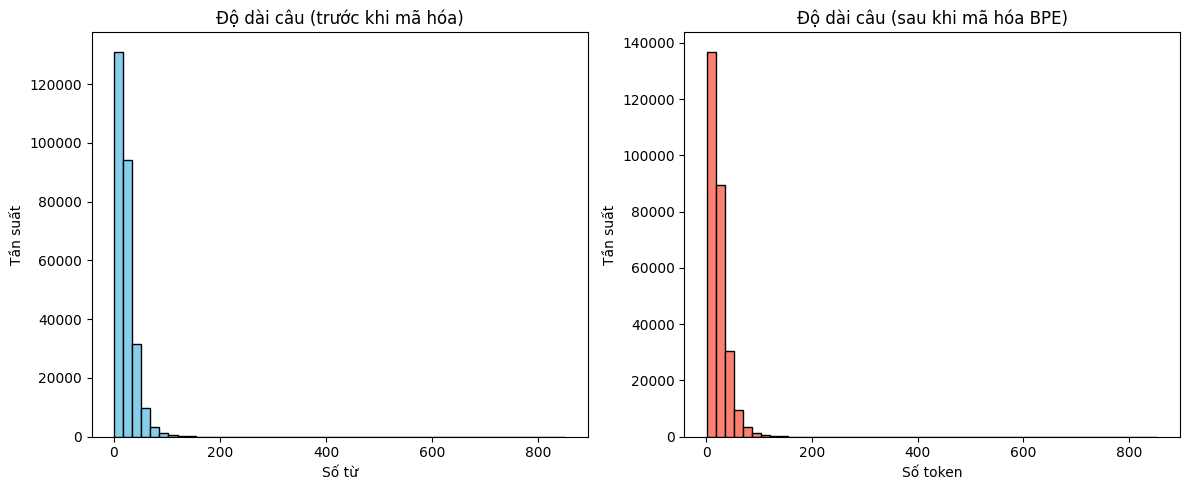


--- Thống kê độ dài câu ---
Trước mã hóa: Trung bình = 22.6, Trung vị = 18.0
Sau mã hóa:   Trung bình = 23.0, Trung vị = 18.0


In [72]:
# Thống kê độ dài câu sau khi mã hóa BPE
def get_lengths(file_paths):
    lengths = []
    for path in file_paths:
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                lengths.append(len(line.strip().split()))
    return lengths

cleaned_files = [os.path.join(data_dir, f.replace(".txt", ".cleaned.txt")) for f in files]
tokenized_files = [os.path.join(data_dir, f.replace(".txt", ".tokenized.txt")) for f in files]

before_lengths = get_lengths(cleaned_files)
after_lengths = get_lengths(tokenized_files)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(before_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Độ dài câu (trước khi mã hóa)")
plt.xlabel("Số từ")
plt.ylabel("Tần suất")

plt.subplot(1, 2, 2)
plt.hist(after_lengths, bins=50, color='salmon', edgecolor='black')
plt.title("Độ dài câu (sau khi mã hóa BPE)")
plt.xlabel("Số token")
plt.ylabel("Tần suất")

plt.tight_layout()
plt.show()

# In thống kê
import numpy as np
print("\n--- Thống kê độ dài câu ---")
print(f"Trước mã hóa: Trung bình = {np.mean(before_lengths):.1f}, Trung vị = {np.median(before_lengths):.1f}")
print(f"Sau mã hóa:   Trung bình = {np.mean(after_lengths):.1f}, Trung vị = {np.median(after_lengths):.1f}")

## Xây dựng và huấn luyện mô hình Encoder-Decoder Transformer từ đầu

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import math
import numpy as np
import os
import evaluate
from sentencepiece import SentencePieceProcessor

In [160]:
class TranslationDataset(Dataset):
    def __init__(self, src_file, tgt_file, sp_model, max_seq_len=100):
        self.src = open(src_file, 'r', encoding='utf-8').readlines()
        self.tgt = open(tgt_file, 'r', encoding='utf-8').readlines()
        self.sp = sp_model
        self.max_seq_len = max_seq_len
        self.vocab_size = sp_model.get_piece_size()

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_line = self.src[idx].strip()
        tgt_line = self.tgt[idx].strip()

        # Mã hóa + giới hạn độ dài câu
        src_ids = self.sp.encode(src_line, out_type=int)[:self.max_seq_len]
        tgt_ids = self.sp.encode(tgt_line, out_type=int)[:self.max_seq_len]

        # Lọc token ID vượt quá vocab_size - 1
        src_ids = [t for t in src_ids if t < self.vocab_size]
        tgt_ids = [t for t in tgt_ids if t < self.vocab_size]

        if len(src_ids) == 0 or len(tgt_ids) == 0:
            print(f"Sample src_ids after filtering: {src_ids}")
            print(f"Max token ID in src: {max(src_ids)}")
            return self.__getitem__((idx + 1) % len(self))  # Bỏ qua nếu dòng trống sau khi lọc

        return {
            'input_ids': torch.tensor(src_ids),
            'labels': torch.tensor(tgt_ids)
        }

In [161]:
def custom_collate_fn(batch):
    src_batch = []
    tgt_batch = []

    for item in batch:
        src = item['input_ids']
        tgt = item['labels']

        if len(src) == 0 or len(tgt) == 0:
            continue  # Bỏ qua mẫu rỗng

        src_batch.append(src)
        tgt_batch.append(tgt)

    if not src_batch:  # Nếu toàn bộ batch bị bỏ qua
        return custom_collate_fn([batch[0]])  # Thử lại với phần tử đầu tiên

    src_batch = pad_sequence(src_batch, padding_value=sp.pad_id(), batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=sp.pad_id(), batch_first=True)

    return {
        'input_ids': src_batch,
        'labels': tgt_batch
    }

In [162]:
data_dir = "/content/data"
sp = SentencePieceProcessor(model_file='bpe.model')

train_dataset = TranslationDataset(
    os.path.join(data_dir, "train.en.cleaned.txt"),
    os.path.join(data_dir, "train.vi.cleaned.txt"),
    sp,
    max_seq_len=100
)

val_dataset = TranslationDataset(
    os.path.join(data_dir, "tst2013.en.cleaned.txt"),
    os.path.join(data_dir, "tst2013.vi.cleaned.txt"),
    sp,
    max_seq_len=100
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)

In [163]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)

        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)

        output = self.transformer(
            src, tgt,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        output = self.fc_out(output)
        return output

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = sp.get_piece_size()
model = TransformerModel(vocab_size=vocab_size, d_model=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [165]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for i, batch in enumerate(dataloader):
        src = batch['input_ids'].to(device)
        tgt = batch['labels'].to(device)

        # Kiểm tra giá trị max token ID
        if src.max() >= model.embedding.num_embeddings or src.min() < 0:
            print("❌ src có token ID không hợp lệ:", src.max().item(), "vs", model.embedding.num_embeddings)
            continue
        if tgt.max() >= model.embedding.num_embeddings or tgt.min() < 0:
            print("❌ tgt có token ID không hợp lệ:", tgt.max().item(), "vs", model.embedding.num_embeddings)
            continue

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        src_key_padding_mask = (src == sp.pad_id()).to(device)
        tgt_key_padding_mask = (tgt_input == sp.pad_id()).to(device)

        output = model(src, tgt_input, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)

        loss = criterion(output.view(-1, vocab_size), tgt_output.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % 50 == 0:
            print(f"Batch {i} | Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch Loss: {avg_loss:.4f}")
    return avg_loss

In [166]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            src = batch['input_ids'].to(device)
            tgt = batch['labels'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            src_key_padding_mask = (src == sp.pad_id()).to(device)
            tgt_key_padding_mask = (tgt_input == sp.pad_id()).to(device)

            output = model(src, tgt_input, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
            loss = criterion(output.view(-1, vocab_size), tgt_output.view(-1))
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss

In [167]:
def translate_sentence(model, src_sentence, sp, max_len=50):
    model.eval()
    tokens = sp.encode(src_sentence.strip(), out_type=int)
    src = torch.tensor(tokens).unsqueeze(0).to(device)

    with torch.no_grad():
        memory = model.encoder(model.pos_encoder(model.embedding(src) * math.sqrt(model.d_model)))
        tgt = torch.tensor([[sp.bos_id()]], device=device)

        for _ in range(max_len):
            tgt_mask = model._generate_square_subsequent_mask(tgt.size(1)).to(device)
            output = model.decoder(tgt, memory, tgt_mask=tgt_mask)
            output = model.fc_out(output)
            last_word_logits = output[0, -1, :]
            _, next_word = torch.max(last_word_logits, dim=-1)
            next_word = next_word.item()

            if next_word == sp.eos_id():
                break

            tgt = torch.cat([tgt, torch.tensor([[next_word]], device=device)], dim=1)

    translated_tokens = tgt.squeeze().tolist()
    return sp.decode(translated_tokens)

In [168]:
def _generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask

In [169]:
print("Tokenizer vocab size:", sp.get_piece_size())
print("Mô hình embedding layer size:", model.embedding.weight.shape[0])

Tokenizer vocab size: 32000
Mô hình embedding layer size: 32000


In [170]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


--- Epoch 1/10 ---
❌ src có token ID không hợp lệ: 31963 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31946 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31912 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31953 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31912 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31963 vs 32000
❌ src có token ID không hợp lệ: 31912 vs 32000
❌ src có token ID không hợp lệ: 31912 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31931 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31908 vs 32000
❌ src có token ID không hợp lệ: 31960 vs 32000
❌ src có token ID không hợp lệ: 31908 vs

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

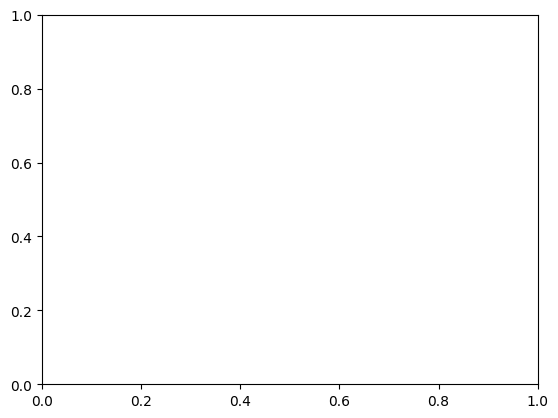

In [121]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sample_sentences = [
    "this is a test sentence",
    "machine learning is fascinating",
    "natural language processing is very powerful"
]

print("\n--- Kết quả dịch mẫu ---")
for sent in sample_sentences:
    translation = translate_sentence(model, sent, sp)
    print(f"Source: {sent}")
    print(f"Translated: {translation}\n")

In [ ]:
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

preds = [translate_sentence(model, s, sp) for s in sample_sentences]
refs = [[s] for s in sample_sentences]  # giả lập tham chiếu

metrics = bleu.compute(predictions=preds, references=refs)
metrics.update(rouge.compute(predictions=preds, references=refs))

print("Đánh giá tự động:", metrics)